# Assigment 2 

In this assigment we will work on a regression algorithm for predicting the stock price on a specific date.

https://www.kdnuggets.com/2023/08/times-series-analysis-arima-models-python.html

# Imports

In [69]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import pickle
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Read data from csv
### We read the file using pandas to 

In [70]:
df = pd.read_csv("../data/TSLA-1yr.csv")  # Read from file, (comma is the default)
df.head()  # Get an overview of the dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-10-28,225.399994,228.860001,216.350006,228.520004,228.520004,69152400
1,2022-10-31,226.190002,229.850006,221.940002,227.539993,227.539993,61554300
2,2022-11-01,234.050003,237.399994,227.279999,227.820007,227.820007,62688800
3,2022-11-02,226.039993,227.869995,214.820007,214.979996,214.979996,63070300
4,2022-11-03,211.360001,221.199997,210.139999,215.309998,215.309998,56538800


In [71]:
# Check if we have any null values in our dataset
print(f"Any null values? {df.isnull().values.any()}")
df.info()  # Check the types for values

Any null values? False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       251 non-null    object 
 1   Open       251 non-null    float64
 2   High       251 non-null    float64
 3   Low        251 non-null    float64
 4   Close      251 non-null    float64
 5   Adj Close  251 non-null    float64
 6   Volume     251 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.9+ KB


We can see that the date column is not recognised, we need to convert it to the right type

## Clean and convert the data

In [72]:
df['Date'] = pd.to_datetime(df['Date'])  # Convert from string to datetime
df = df.set_index('Date')  # Set the date to be the index 
print(df.head())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-10-28  225.399994  228.860001  216.350006  228.520004  228.520004   
2022-10-31  226.190002  229.850006  221.940002  227.539993  227.539993   
2022-11-01  234.050003  237.399994  227.279999  227.820007  227.820007   
2022-11-02  226.039993  227.869995  214.820007  214.979996  214.979996   
2022-11-03  211.360001  221.199997  210.139999  215.309998  215.309998   

              Volume  
Date                  
2022-10-28  69152400  
2022-10-31  61554300  
2022-11-01  62688800  
2022-11-02  63070300  
2022-11-03  56538800  


## See correlations if any

In [73]:
#df.corr()
#sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")  #Seaborn plot


We can see that Close and Adj Close is the same ^

In [74]:
df = df.drop(['Adj Close'], axis='columns')  # Drop the 'Adj Close' column

### Visualize the data

Text(0.5, 1.0, 'TSLA - Closing price')

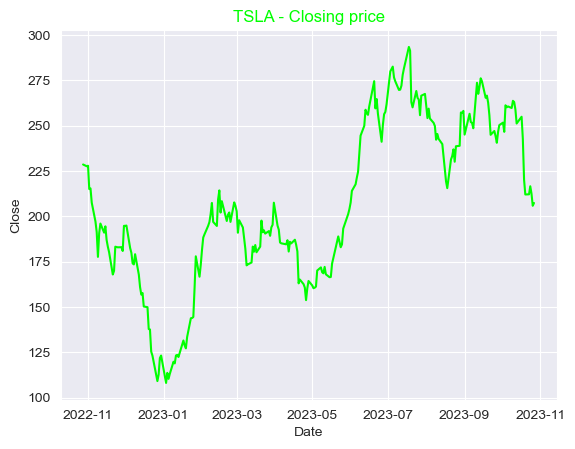

In [75]:
sns.lineplot(df, x='Date', y='Close', color='lime')
plt.title("TSLA - Closing price", color='lime')

Text(0.5, 1.0, 'TSLA - Volume')

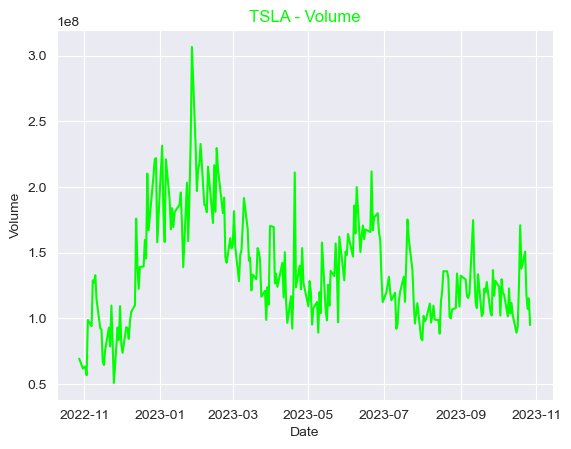

In [76]:
sns.lineplot(df, x='Date', y='Volume', color='lime')
plt.title("TSLA - Volume", color='lime')

### Check distribution using boxplots

Text(0.5, 1.0, 'TSLA - Distribution of closing price ')

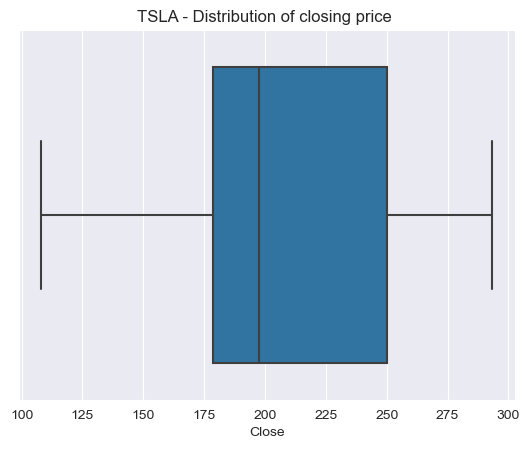

In [77]:
sns.boxplot(df, x='Close')
plt.title("TSLA - Distribution of closing price ")

We can observe outliers significantly distant from the upper quartiles, to fix this we can remove the outliers that fall outside the top 75 % and lower 25 % 

## Remove outliers

In [78]:
# Calculate the IQR for closing price
Q1 = df['Close'].quantile(0.25)  # Lower half
Q3 = df['Close'].quantile(0.75)  # Upper half
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove rows outside the bounds
df = df[(df['Close'] >= lower_bound) & (df['Close'] <= upper_bound)]

### Check distribution after removing outliers

Text(0.5, 1.0, 'TSLA - Distribution of closing price after removing outliers')

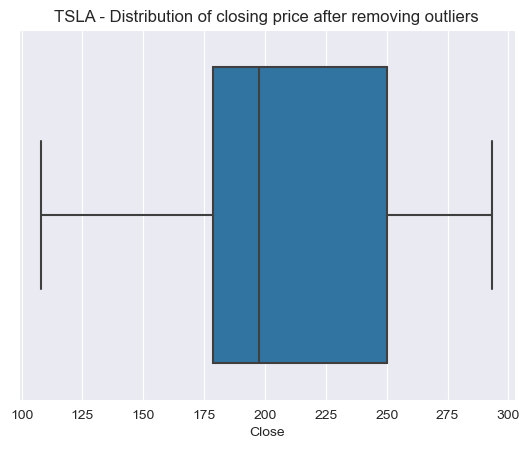

In [79]:
sns.boxplot(df, x='Close')
plt.title("TSLA - Distribution of closing price after removing outliers")

We can see now that the distribution is much better, we only have some outliers. 

### Visualize the data after removing outliers

Text(0.5, 1.0, 'TSLA - Closing price')

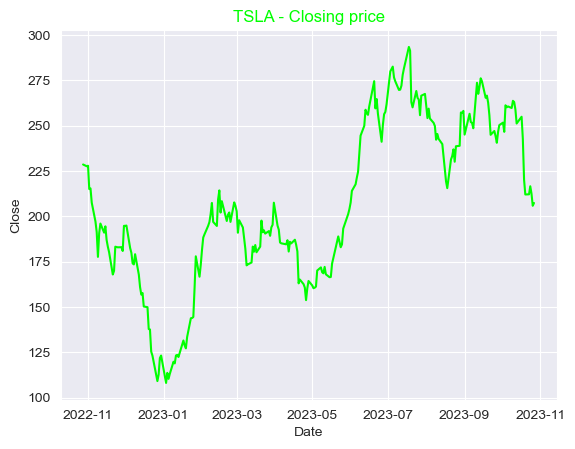

In [80]:
sns.lineplot(df, x='Date', y='Close', color='lime')
plt.title("TSLA - Closing price", color='lime')

Text(0.5, 1.0, 'TSLA - Volume')

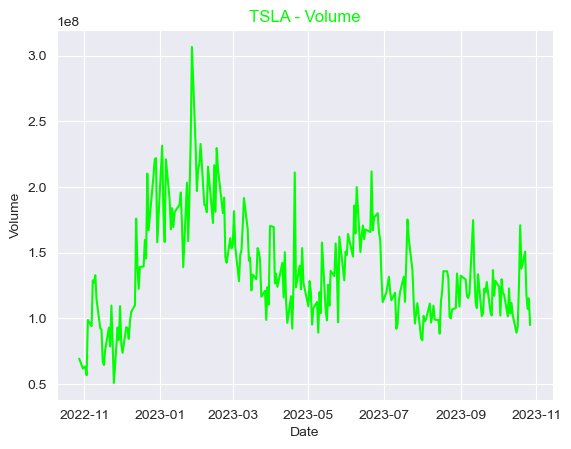

In [81]:
sns.lineplot(df, x='Date', y='Volume', color='lime')
plt.title("TSLA - Volume", color='lime')

### Train the model

## Splitting the training and testing set

In [82]:
# Based on https://www.kdnuggets.com/2023/08/times-series-analysis-arima-models-python.html

# Change this value to set a different test size
test_size = 0.33

train_size = int(len(df) * (1 - test_size))  # Calculate how large portion that should be used for testing. 

# Take training data from the start of the dataframe, then use the rest for testing data
train_data, test_data = df[0:train_size], df[train_size:]
train_data, test_data = train_data['Close'], test_data['Close']  # Train and test from the Close column 

In [83]:
# Initial data setup
training_history = [x for x in train_data]  # Create a copy of the training data
predictions = []  # Store model predictions
y = test_data

arima_order = (1, 1, 0)  # ARIMA model order
model = None  # This is defined here, so we can use the same ARIMA model after training.

# Rolling forecasts
for i in range(len(y)):
    # Initialize the model with the training history and the arima order set
    model = ARIMA(training_history, order=arima_order)

    #Train the ARIMA model
    model_fit = model.fit()

    # Make a one-step-ahead forecast
    forecasted_value = model_fit.forecast()[0]

    # Append the forecasted value to the predictions list
    predictions.append(forecasted_value)

    # Update the training history with the observed value
    training_history.append(y[i])



### Show the results

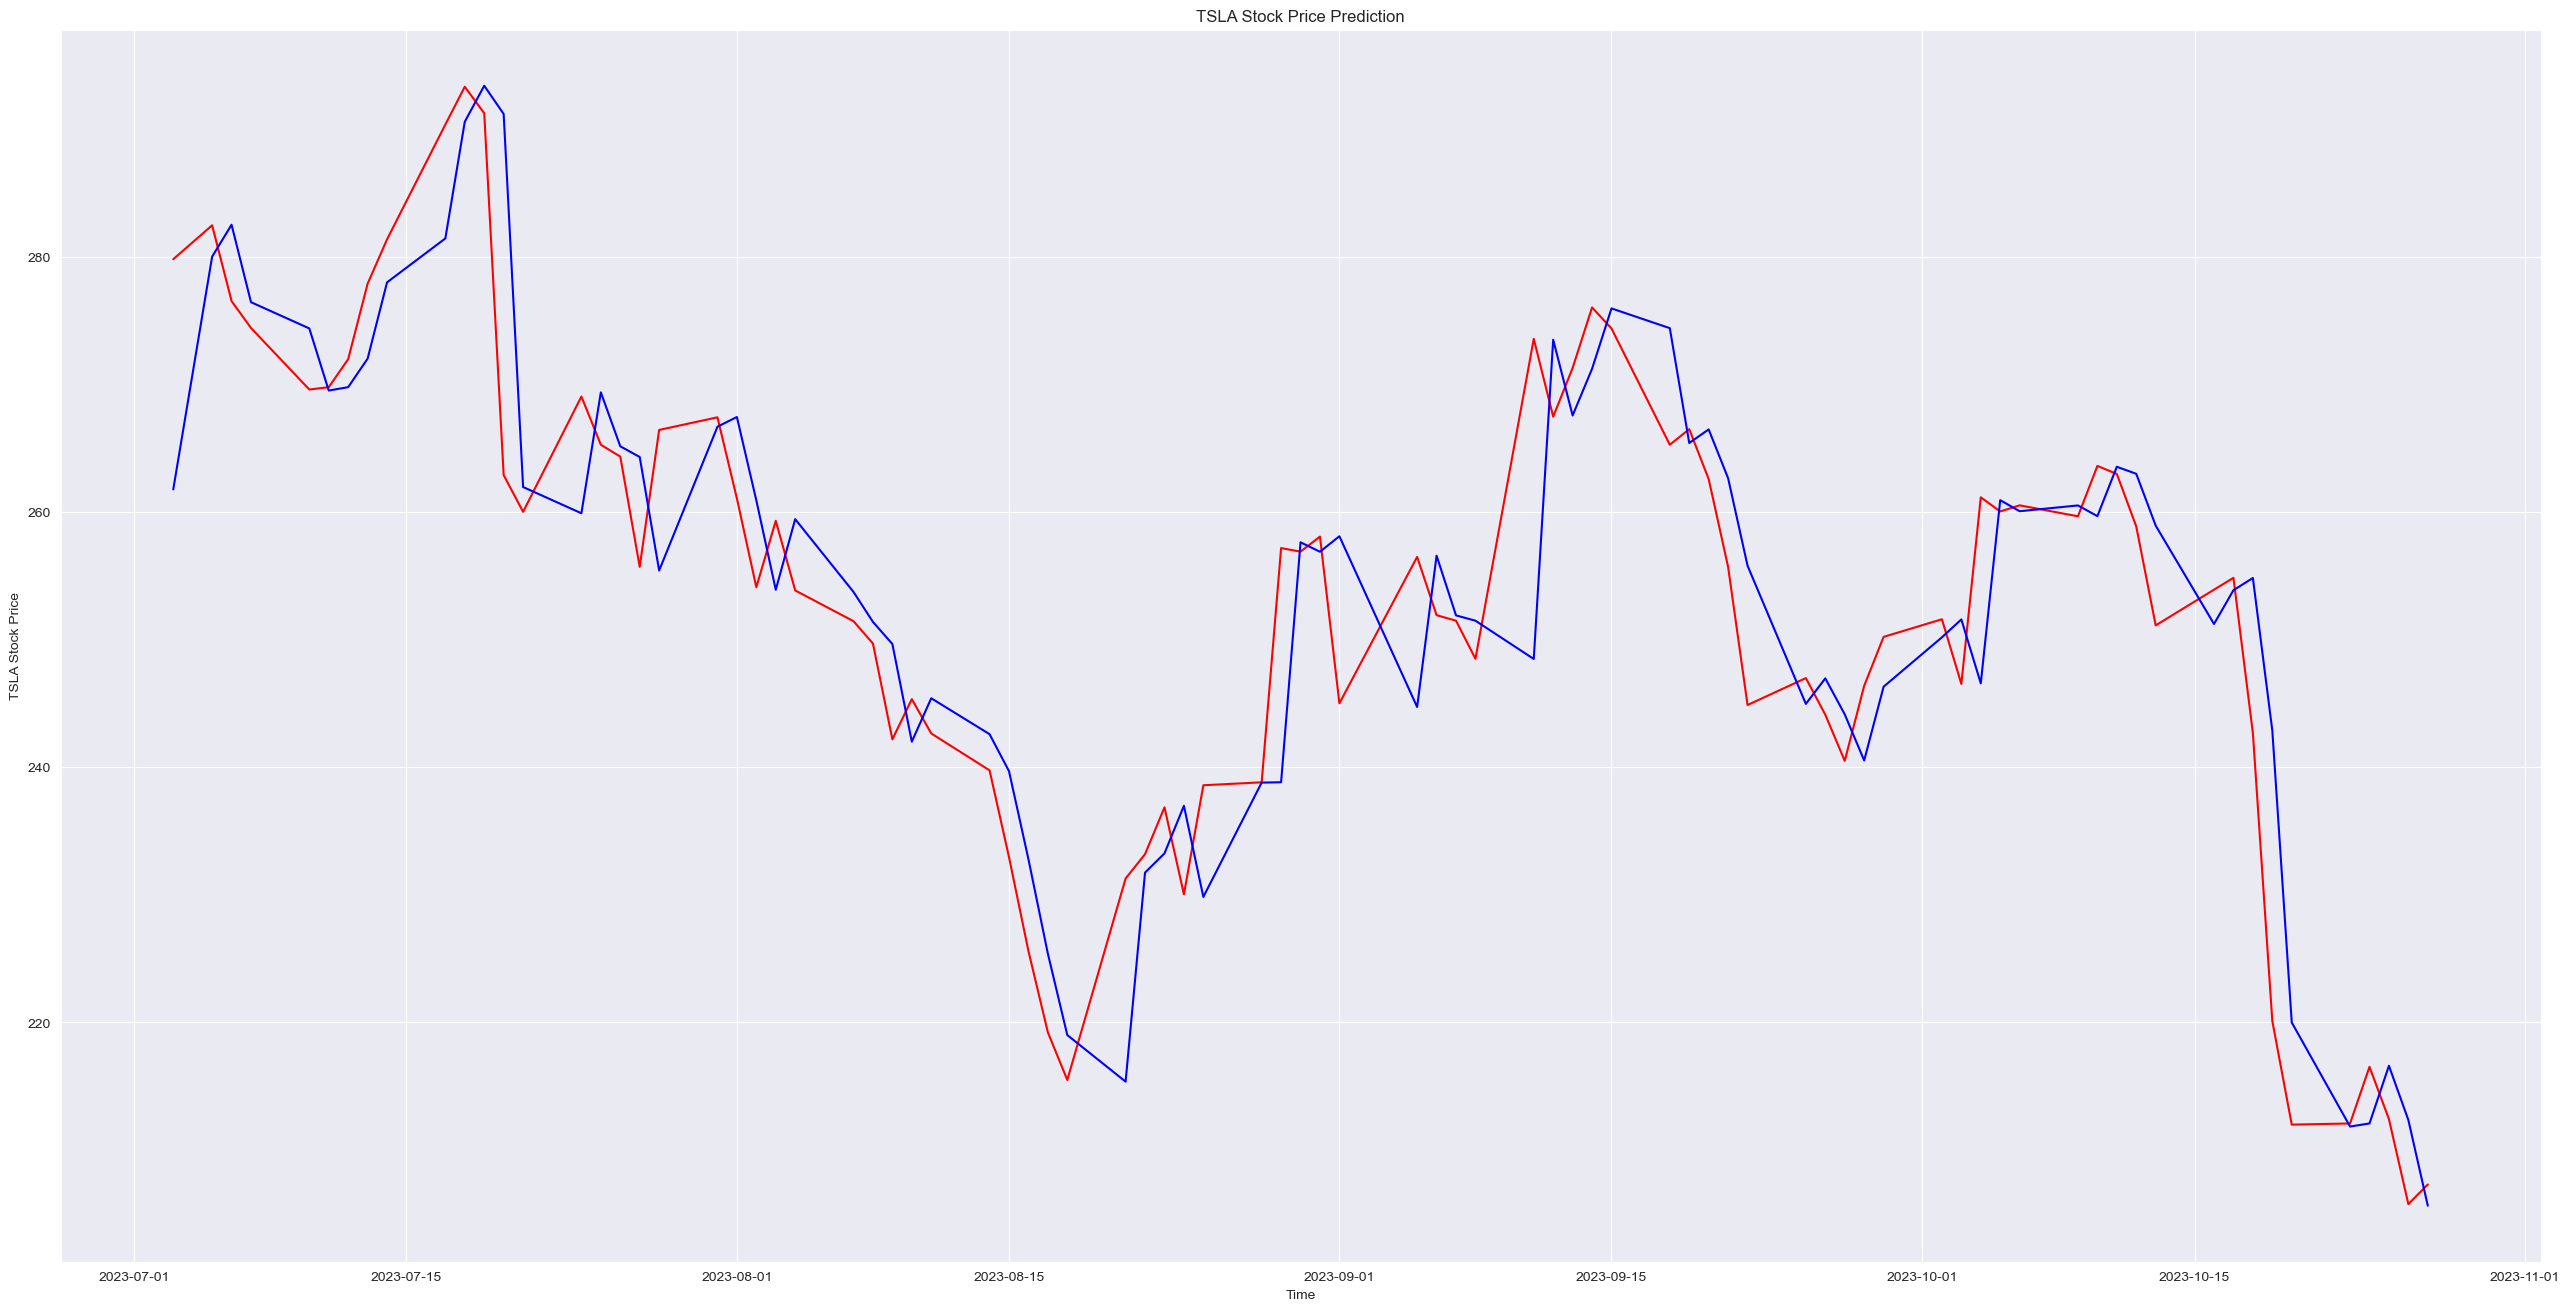

In [84]:
plt.figure(figsize=(32, 16))
plt.plot(test_data.index, y, color="red", label="Real closing price")
plt.plot(test_data.index, predictions, color='blue', label='Predicted closing price')
plt.title('TSLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TSLA Stock Price')
plt.show()

mse = mean_squared_error(y, predictions)

In [85]:
model_fit = model.fit()
# Forecast
print(model_fit.forecast()[0])  # is 205.63339079331718

filename = "TSLA-ARIMA.cc"
pickle.dump(model, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))
model_fit = loaded_model.fit()

# Forecast
print(model_fit.forecast()[0])  # Should be and is 205.63339079331718


205.63339079331718
[205.63339079 205.63097506 205.63092897 205.63092809 205.63092807
 205.63092807 205.63092807 205.63092807 205.63092807 205.63092807]
